In [1]:
!pip install keras_applications
!pip install keras_vggface
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.7 MB/s eta 0:00:00


In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
import os
import re
import cv2
from PIL import Image
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Flatten,Dense,Input,Dropout,Activation,BatchNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Error **No module named 'keras.engine.topology'** 

buka /usr/local/lib/python3.10/dist-packages/keras_vggface/models.py 

dari:
from keras.engine.topology import get_source_inputs


jadi:
from keras.utils.layer_utils import get_source_inputs


In [70]:
all_images = os.listdir('/content/drive/MyDrive/Capstone/face2hwg/new/train_aligned')
train = pd.read_csv('/content/drive/MyDrive/Capstone/face2hwg/new/new/train.csv')
valid = pd.read_csv('/content/drive/MyDrive/Capstone/face2hwg/new/new/test.csv')
valid['gender'] = valid['sex'].map(lambda i: 1 if i == 'Male' else 0)

train = train.loc[train['index'].isin(all_images)]
valid = valid.loc[valid['index'].isin(all_images)]

In [15]:
train.head()

,nameid,bookid,name,sex,height,weight,index
0,7482,248038,JAMES DEYO ROBINSON,Male,1.8034,122.0576,248038.jpg
1,754952,250464,CORDERRO ALTON LAURENCE,Male,1.8034,91.5432,250464.jpg
2,644421,263711,TAYLOR LOUIS HARLAN,Male,1.7526,126.4168,263711.jpg
3,699804,270020,MALIK TYRONE MANDUJANO,Male,1.6002,56.6696,270020.jpg
4,238047,277774,DUSTIN GLEN BLACK,Male,1.8796,100.2616,277774.jpg


In [51]:
# resize dan preprocessing
def process_arr(arr, version):
    img = cv2.resize(arr, (224, 224))
    img = np.expand_dims(img, 0)
    img = utils.preprocess_input(img, version = version)
    return img

## Mengubah banyak image ke array dalam array dengan function img2arr
def imgs2arr(img_names, img_dir, version = 1):
    imgs = []
    for img in img_names:
        imgs += [img2arr(os.path.join(img_dir,img), version)]
    return np.concatenate(imgs)

## Mengubah image ke array
def img2arr(img_path, version):
  img = tf.keras.utils.load_img(img_path)
  img = tf.keras.utils.img_to_array(img)
  img = process_arr(img,version)
  return img

# generate image ke beberapa batch
def input_generator(data, bs, img_dir, is_train=True, version=1):
  sex_map={'Male':1, 'Female':0}
  loop = True

  while loop:
    if is_train:
      sampled = data.sample(bs)
      x = imgs2arr(sampled['index'],img_dir, version)
      y = [sampled['height'].values, sampled['weight'].values, sampled['sex'].map(lambda i: sex_map.get(i,0)).values]
      res = (x,y)
    else:
      if len(data) >= bs:
        sampled = data.iloc[:bs,:]
        data = data.iloc[bs:,:]
        res = imgs2arr(sampled['index'],img_dir, version)
      else: 
        loop = False
    yield res

In [52]:
train_data_gen = input_generator(train,8,'/content/drive/MyDrive/Capstone/face2hwg/new/train_aligned',True,1)
valid_data_gen = input_generator(valid,8,'/content/drive/MyDrive/Capstone/face2hwg/new/train_aligned',True,1)
train_data_gen

<generator object input_generator at 0x7fa0916f3bc0>

In [53]:
vgg_model = VGGFace(model='vgg16',include_top=True,input_shape=(224,224,3))
last_layer = vgg_model.get_layer('fc6').output
flatten = Activation('relu')(last_layer)

for layer in vgg_model.layers:
  layer.trainable = False

def layer(flatten, name):
  x = Dense(128, name=name + '_fc1')(flatten)
  x = BatchNormalization(name = name + '_bn1')(x)
  x = Activation('relu', name = name+'_act1')(x)
  x = Dropout(0.0)(x)
  x = Dense(128, name=name + '_fc2')(x)
  x = BatchNormalization(name = name + '_bn2')(x)
  x = Activation('relu', name = name+'_act2')(x)
  x = Dropout(0.0)(x)
  return x

x = layer(flatten, name='sex')
out_sex = Dense(1, activation = 'sigmoid', name='sex')(x)

x1 = Dense(128)(flatten)
x1 = Add()([x1,x])
x1 = layer(x1, name='height')
out_height = Dense(1, activation ='linear', name = 'height')(x1)

x2 = Dense(128)(flatten)
x2 = Add()([x2,x])
x2 = layer(x2, name='weight')
out_weight = Dense(1, activation ='linear', name = 'weight')(x2)


In [54]:
model = Model(vgg_model.input,[out_height, out_weight, out_sex])

In [55]:
model.compile('adam',
              {'weight':'mae','height':'mae','sex':'binary_crossentropy'},
              metrics=['accuracy'],
              loss_weights={'weight':0.8,'height':0.8,'sex':0.1})

In [56]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 224, 224, 64  36928       ['conv1_1[0][0]']                
                                )                                                           

In [57]:
model_type = 'vgg16'
es = EarlyStopping(patience=3)
callbacks = [es]

In [58]:
history = model.fit(train_data_gen,
          batch_size=len(train)//8,
          epochs=20,
          validation_data=valid_data_gen,
          validation_steps=len(valid)//8,
          callbacks=callbacks,
          steps_per_epoch=149)

Epoch 1/20
149/149 [==============================] - 987s 7s/step - loss: 58.5392 - height_loss: 0.5504 - weight_loss: 72.5968 - sex_loss: 0.2143 - height_accuracy: 0.0000e+00 - weight_accuracy: 0.0000e+00 - sex_accuracy: 0.9279 - val_loss: 49.9431 - val_height_loss: 0.4814 - val_weight_loss: 61.9386 - val_sex_loss: 0.0707 - val_height_accuracy: 0.0000e+00 - val_weight_accuracy: 0.0000e+00 - val_sex_accuracy: 0.9826
Epoch 2/20
149/149 [==============================] - 957s 6s/step - loss: 45.2274 - height_loss: 0.2473 - weight_loss: 56.2754 - sex_loss: 0.0920 - height_accuracy: 0.0000e+00 - weight_accuracy: 0.0000e+00 - sex_accuracy: 0.9715 - val_loss: 40.7171 - val_height_loss: 0.2656 - val_weight_loss: 50.6211 - val_sex_loss: 0.0779 - val_height_accuracy: 0.0000e+00 - val_weight_accuracy: 0.0000e+00 - val_sex_accuracy: 0.9826
Epoch 3/20
149/149 [==============================] - 965s 6s/step - loss: 22.7544 - height_loss: 0.1790 - weight_loss: 28.2545 - sex_loss: 0.0762 - height_ac

<function matplotlib.pyplot.show(close=None, block=None)>

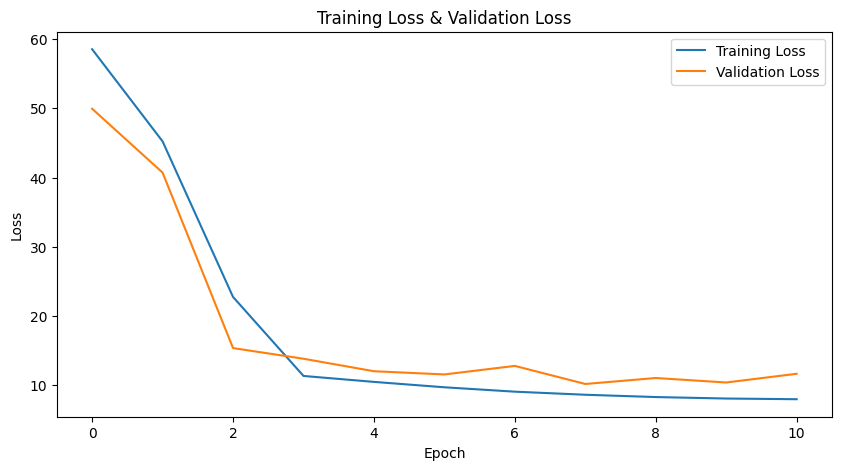

In [59]:
# Adam
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.title("Training Loss & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show

In [72]:
valid.gender

0      1
1      1
2      1
3      1
4      1
      ..
284    0
285    1
286    1
287    1
288    1
Name: gender, Length: 289, dtype: int64

In [74]:
## Evaluasi Model

array = imgs2arr(valid['index'].values, '/content/drive/MyDrive/Capstone/face2hwg/new/train_aligned')
height, weight, sex = model.predict(array)
metrics = {'weight_mae':mean_absolute_error(height[:,0], valid.height.values),
           'height_mae':mean_absolute_error(weight[:,0], valid.weight.values),
           'sex_auc': roc_auc_score(valid.gender, sex[:,0])}
print(metrics)

10/10 [==============================] - 194s 19s/step
{'weight_mae': 0.10584743639421297, 'height_mae': 13.427245054859835, 'sex_auc': 0.9939592430858806}


In [75]:
model.save('/content/drive/MyDrive/Capstone/face2hwg/model_2{:s}.h5'.format(model_type))

In [76]:
model_save = load_model('/content/drive/MyDrive/Capstone/face2hwg/model_2{:s}.h5'.format(model_type))

1/1 [==============================] - 2s 2s/step
Height:1.7
Weight:90
SEX:M


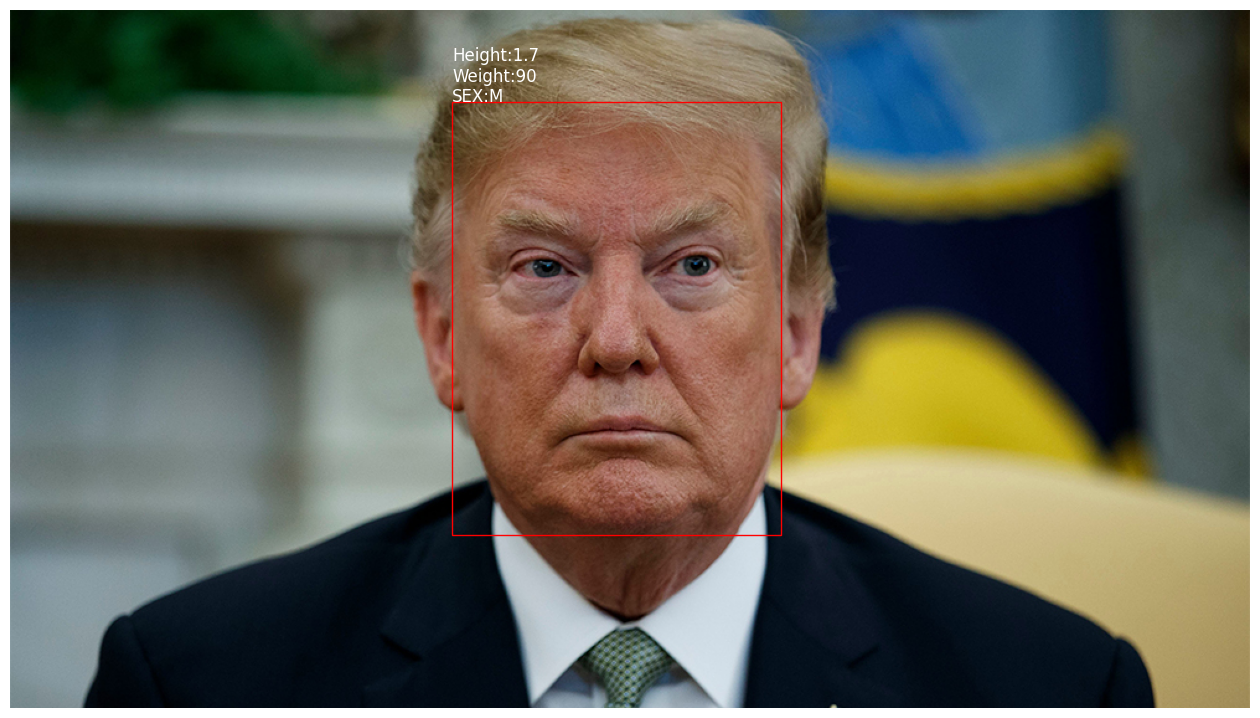

In [77]:
mtcnn = MTCNN()
def crop_image(image, x, y, w, h):
  return image[y:(y+h),x:(x+w),:]

def detect_faces(face_path, confidence):
  image = face_path
  image = tf.keras.utils.load_img(image)
  image = tf.keras.utils.img_to_array(image)
  box = mtcnn.detect_faces(image)
  box = [i for i in box if i['confidence'] > confidence]
  res = [crop_image(image, *i['box']) for i in box]
  res = [process_arr(i, 1) for i in res]
  return box, res

# Start to Predict 
img_dir = '/content/drive/MyDrive/Capstone/face2hwg/new/single_face/trump.jpg'
assert os.path.isfile(img_dir), ' cuma satu gambar yang support'
img = cv2.cvtColor(cv2.imread(img_dir),cv2.COLOR_BGR2RGB)
boxes, faces = detect_faces(img_dir, 0.95)
preds = [model_save.predict(face) for face in faces]

num_box = len(boxes)
fig,ax = plt.subplots()
fig.set_size_inches(16,12)
# Display the image
ax.imshow(img)
ax.axis('off')
# Create a Rectangle patch
for idx, box in enumerate(boxes):
  height, weight, sex = preds[idx]
  box_x, box_y, box_w, box_h = box['box']
  rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  ax.text(box_x, box_y, 
          'Height:{:3.1f}\nWeight:{:02.0f}\nSEX:{:s}'.format(height[0,0], weight[0,0], 'M' if sex[0,0] > 0.05 else 'F'),
          color = "white", fontsize = 12)

print('Height:{:3.1f}\nWeight:{:02.0f}\nSEX:{:s}'.format(height[0,0], weight[0,0], 'M' if sex[0,0] > 0.05 else 'F'))
plt.show()